In [1]:
import numpy as np
import open3d as o3d
import pandas
import cv2
import scipy.ndimage
from open3d import JVisualizer
import copy
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from lxml.etree import Element, SubElement, Comment, tostring
import lxml.etree as etree
import math as m


from PIL import Image
from scipy.sparse.linalg import svds
import pickle
import mat73


# pixel_per_meter = 4801.4
# ipad_height_pixel = 1440.
# ipad_width_pixel = 1080.
up_side_down = False

pixel_per_meter = 10296.3 
ipad_height_pixel = 3088.
ipad_width_pixel = 2316.
depth_height = 640
depth_width = 480
#per meter
scale = 1000
coeff = ipad_height_pixel/depth_height

#pinhole camera insintrict of ipad pro 11-inch 2018 (see the terminal output of the swift program)
fx = 2872.9004 
fy = 2872.9004 
ox = 1538.0475 
oy = 1154.8513 

if ipad_height_pixel < 3088:
    fx = fx /3088. * ipad_height_pixel
    fy = fy /3088. * ipad_height_pixel
    ox = ox /3088. * ipad_height_pixel
    oy = oy /3088. * ipad_height_pixel

center_x = (ox / pixel_per_meter)
center_y = (oy / pixel_per_meter)

color_path_to = '/Users/tianyizuo/Desktop/Captures/standard/mid/full.jpg'
depth_path_to = '/Users/tianyizuo/Desktop/Captures/standard/mid/depth.txt'
mask_path_to = '/Users/tianyizuo/Desktop/Captures/standard/mid/mask.jpg'
landmark_path_to = '/Users/tianyizuo/Desktop/Captures/standard/mid/landmark.txt'

color_path_from = '/Users/tianyizuo/Desktop/Captures/standard/toleft/full.jpg'
depth_path_from = '/Users/tianyizuo/Desktop/Captures/standard/toleft/depth.txt'
mask_path_from = '/Users/tianyizuo/Desktop/Captures/standard/toleft/mask.jpg'
landmark_path_from = '/Users/tianyizuo/Desktop/Captures/standard/toleft/landmark.txt'

#the maximum distance in which the search tried to find a correspondence for each point
threshold = 0.1 # in meters

facial_midpoints = np.array([46, 47, 48, 49, 52, 30, 40, 41, 37, 67])
inner_face_id = 59


In [2]:
def Rx(theta):
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, m.cos(theta),-m.sin(theta)],
                   [ 0, m.sin(theta), m.cos(theta)]])
 
def Ry(theta):
    return np.matrix([[ m.cos(theta), 0, m.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-m.sin(theta), 0, m.cos(theta)]])
 
def Rz(theta):
    return np.matrix([[ m.cos(theta), -m.sin(theta), 0 ],
                   [ m.sin(theta), m.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])

In [3]:
def create_picked_points(pickedPointsPath, landmarks, objPath):

    # <!DOCTYPE PickedPoints>
    # <PickedPoints>
    #  <DocumentData>
    #   <DataFileName name="tz2617_masked_open_mouth.obj"/>
    #   <templateName name=""/>
    #  </DocumentData>

    picked_points = Element('PickedPoints')
    document_data = SubElement(picked_points, 'DocumentData')
    data_file_name = SubElement(document_data, 'DataFileName',
                                 {'name':objPath.split('/')[-1]})
    template_name = SubElement(document_data, 'templateName',
                                 {'name':''})

    #  <point name="1" z="0.25358397" active="1" x="0.031310152" y="-0.056594905"/>
    for i in range(landmarks.shape[0]):
        x, y, z = landmarks[i]
        SubElement(picked_points, 'point', {'name':str(i+1), 'active':str(1), 'x': str(x), 'y': str(y), 'z': str(z)})

    picked_points_xml = etree.tostring(picked_points, encoding="UTF-8",
                         xml_declaration=True,
                         pretty_print=True,
                         doctype='<!DOCTYPE PickedPoints>').decode("utf-8") 
#     print(picked_points_xml)
    f = open(pickedPointsPath, "w")
    f.write(picked_points_xml)
    f.close()

def generate_pcd(color_path, depth_path, mask_path, landmark_path):
    color_raw = cv2.imread(color_path)
    color_raw = cv2.cvtColor(color_raw, cv2.COLOR_BGR2RGB)
    color_raw = o3d.geometry.Image((color_raw).astype(np.uint8))
    img = pandas.read_csv(depth_path, header=None)
    landmarks = pandas.read_csv(landmark_path, header=None).to_numpy()
    depth_raw = np.zeros((depth_height, depth_width))
    h = depth_height
    w = depth_width
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if ipad_height_pixel == 3088.:
        mask = mask.repeat(2, axis=0).repeat(2, axis=1) #upsample
    mask = (mask > 250)
    print(mask.shape)
    instrinct = o3d.camera.PinholeCameraIntrinsic()
    if up_side_down:
        instrinct.set_intrinsics(int(ipad_height_pixel), int(ipad_width_pixel), fx, fy, ipad_width_pixel - ox, ipad_height_pixel - oy)
    else:
        instrinct.set_intrinsics(int(ipad_height_pixel), int(ipad_width_pixel), fx, fy, ox, oy)

    if up_side_down:
        for u in range(h):
            for v in range(w):
                    depth_raw[u, v] = 1./ img.iloc[v, h - 1 - u] # np.sqrt(max(0, np.power(1./img.iloc[v, h - 1 - u], 2) + np.power(u/pixel_per_meter, 2)))
    else:
        for u in range(h):
            for v in range(w):
                    depth_raw[u, v] = 1./ img.iloc[-v, u] #np.sqrt(max(0, np.power(1./img.iloc[-v, u], 2) - np.power(u/pixel_per_meter, 2)))
    depth_raw = scipy.ndimage.zoom(depth_raw, coeff, order=1) * scale 
    depth_raw = np.expand_dims(depth_raw, axis=2).astype(np.uint16)
    
    print(depth_raw.shape)
    index = 0
    index_array = np.zeros((int(ipad_height_pixel), int(ipad_width_pixel)), int)
    for x in range(int(ipad_height_pixel)):
        for y in range(int(ipad_width_pixel)):
            if not mask[x, y]:
                depth_raw[x, y] = 0 #set to invalid value
            else:
                index += 1
                index_array[x, y] = index
    landmarks_3d = np.zeros((landmarks.shape[0], 3))
    plt.figure()
    plt.imshow(color_raw)
    plt.scatter(landmarks[:, 1], landmarks[:, 0])
    plt.show()
    depth_raw = o3d.geometry.Image(depth_raw)
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw, depth_trunc=1., convert_rgb_to_intensity=False)
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, instrinct)
    pcd.translate((center_x, center_y, 0)) # change the center to the focal point
    pcd.rotate(Rx(m.pi)) #180 degree along z axis to make it facing us!
    print(pcd)
    pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(
        radius=0.05, max_nn=8))

    point_cloud_array = np.asarray(pcd.points)
    for i in range(landmarks.shape[0]):
        x = int(landmarks[i][0])
        y = int(landmarks[i][1])
        landmarks_3d[i] = point_cloud_array[index_array[x, y] - 1]
    normal_from_depth = np.zeros((int(ipad_height_pixel), int(ipad_width_pixel), 3))
    normals_np = np.asarray(pcd.normals)
    print("normals shape: ", normals_np.shape)
    print("index : ", index)
    for x in range(int(ipad_height_pixel)):
        for y in range(int(ipad_width_pixel)):
            i = index_array[x, y]
            if i > 0 and i < index - 1:
                normal_from_depth[x, y] = normals_np[i - 1] 
    return pcd, landmarks_3d, normal_from_depth


def generate_pcd_lowres(color_path, depth_path, mask_path, landmark_path):
    h = depth_height
    w = depth_width
    color_raw = cv2.imread(color_path)
    #downsample to 640 x 480
    color_raw = cv2.resize(color_raw, dsize=(w, h), interpolation=cv2.INTER_CUBIC)
    color_raw = cv2.cvtColor(color_raw, cv2.COLOR_BGR2RGB)
    color_raw = o3d.geometry.Image((color_raw).astype(np.uint8))
    img = pandas.read_csv(depth_path, header=None)
    landmarks = pandas.read_csv(landmark_path, header=None).to_numpy()
    depth_raw = np.zeros((h, w))
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    #down sample to 640 x 480
    mask = cv2.resize(mask, dsize=(w, h), interpolation=cv2.INTER_CUBIC)
    mask = (mask > 230)
    print(mask.shape)
    instrinct = o3d.camera.PinholeCameraIntrinsic()
    if up_side_down:
        instrinct.set_intrinsics(h, w, fx/coeff, fy/coeff, (ipad_width_pixel - ox)/coeff, (ipad_height_pixel - oy)/coeff)
    else:
        instrinct.set_intrinsics(h, w, fx/coeff, fy/coeff, ox/coeff, oy/coeff)

    if up_side_down:
        for u in range(h):
            for v in range(w):
                    depth_raw[u, v] = 1./ img.iloc[v, h - 1 - u] # np.sqrt(max(0, np.power(1./img.iloc[v, h - 1 - u], 2) + np.power(u/pixel_per_meter, 2)))
    else:
        for u in range(h):
            for v in range(w):
                    depth_raw[u, v] = 1./ img.iloc[-v, u] #np.sqrt(max(0, np.power(1./img.iloc[-v, u], 2) - np.power(u/pixel_per_meter, 2)))
    
    depth_raw *= scale 
    depth_raw = np.expand_dims(depth_raw, axis=2).astype(np.uint16)
    
    print(depth_raw.shape)
    index = 0
    index_array = np.zeros((h, w), int)
    for x in range(h):
        for y in range(w):
            if not mask[x, y]:
                depth_raw[x, y] = 0 #set to invalid value
            else:
                index += 1
                index_array[x, y] = index
    landmarks_3d = np.zeros((landmarks.shape[0], 3))
    plt.figure()
    plt.imshow(color_raw)
    plt.scatter(landmarks[:, 1]/coeff, landmarks[:, 0]/coeff)
    plt.show()
    depth_raw = o3d.geometry.Image(depth_raw)
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw, depth_trunc=1., convert_rgb_to_intensity=False)
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, instrinct)
    print("rotating")
    pcd.translate((center_x, center_y, 0)) # change the center to the focal point
    pcd.rotate(Rx(m.pi)) #180 degree rotation to make it facing us!
    print(pcd)
    pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(
        radius=0.01, max_nn=4))
    point_cloud_array = np.asarray(pcd.points)
    normals = np.asarray(pcd.normals)
    for i in range(landmarks.shape[0]):
        x = int(landmarks[i][0]/coeff)
        y = int(landmarks[i][1]/coeff)
        landmarks_3d[i] = (point_cloud_array[index_array[x, y] - 1] / coeff)  
#     o3d.visualization.draw_geometries([pcd])
    return pcd, landmarks_3d, normals



(640, 480)
(640, 480, 1)


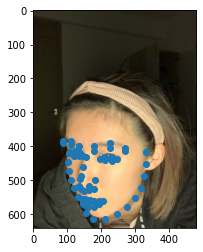

rotating
PointCloud with 60527 points.
(640, 480)
(640, 480, 1)


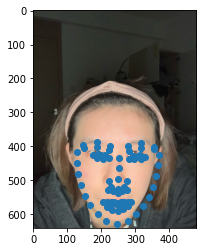

rotating
PointCloud with 67701 points.


True

In [4]:
# visualizer = JVisualizer()
# visualizer.add_geometry(pcd)
# visualizer.show()

pcd_from, landmark_from, normal_from = generate_pcd_lowres(color_path_from, depth_path_from, mask_path_from, landmark_path_from)
pcd_to, landmark_to, normal_to = generate_pcd_lowres(color_path_to, depth_path_to, mask_path_to, landmark_path_to)

o3d.io.write_point_cloud("./point_cloud/usd_mid_rotate.ply", pcd_to) # for meshlab visualization
o3d.io.write_point_cloud("./point_cloud/usd_toright_rotate.ply", pcd_from)



In [5]:
def get_mesh(pcd):
    distances = pcd.compute_nearest_neighbor_distance()
    avg_dist = np.mean(distances)
    radius = 1.5 * avg_dist   
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
               pcd,
               o3d.utility.DoubleVector([radius, radius * 2]))
    return mesh

In [ ]:
# create_picked_points("./point_cloud/usd_mid.pp", landmark_to, "./point_cloud/usd_mid.ply")
# create_picked_points("./point_cloud/usd_toright.pp", landmark_from, "./point_cloud/usd_toright.ply")



In [6]:
print(landmark_from.shape)
print(landmark_to.shape)

(76, 3)
(76, 3)


In [7]:
def find_affine(points_from, points_to, use_face = False):
    valid_points_from = []
    valid_points_to = []
    if use_face:
        end = points_from.shape[0]
    else:
        end = inner_face_id
    for i in range(end): #some points can be outside of the face area hence have location (0, 0, 0)
        if points_from[i].sum() != 0 and points_to[i].sum() != 0:
            valid_points_from.append(points_from[i])
            valid_points_to.append(points_to[i])
    p_from = np.stack(valid_points_from)
    p_to = np.stack(valid_points_to)
    #Append a column of 1 to the end of p_from
    p_from_ = np.ones((p_from.shape[0], p_from.shape[1] + 1))
    p_from_[:, :-1] = p_from
    p_to_ = np.ones((p_from.shape[0], p_from.shape[1] + 1))
    p_to_[:, :-1] = p_to
    #p_to_ = A * p_from_
    #A = p_to_ * p_from_^(-1)
    A,resid,rank,sing = np.linalg.lstsq(p_from_, p_to_) #solving for least square
    print(rank)
    return A.T

In [8]:
trans_init = find_affine (landmark_from, landmark_to)

4


<ipython-input-7-83c8d65bdbe7>:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  A,resid,rank,sing = np.linalg.lstsq(p_from_, p_to_) #solving for least square


In [9]:
print(trans_init)

[[ 8.68664359e-01 -2.12381432e-02  3.61239995e-01 -2.21273888e-02]
 [ 3.96340345e-01  9.78698660e-01 -1.26890815e+00  1.03315412e-01]
 [-1.57728202e-01 -7.32520163e-02  2.32299083e-01  4.58919760e-02]
 [-4.43860400e-15  2.87498510e-15 -3.79293574e-15  1.00000000e+00]]


In [10]:
# print(result_ransac.transformation)
test_transform = copy.deepcopy(pcd_from)
test_transform.transform(trans_init)
o3d.io.write_point_cloud("./point_cloud/usd_toright_icp_rotated_affine.ply", test_transform)

True

In [11]:
# # ICP registration performs the best when two models have overlaps of over 75% so we use landmark or global icp
# # to roughly decide the initial transformation
# reg_p2p = o3d.pipelines.registration.registration_icp(
#     pcd_from, pcd_to, threshold, trans_init,
#    o3d.pipelines.registration.TransformationEstimationPointToPlane(),
#    o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=5000)
# )
# print(reg_p2p)
# print("Transformation is:")
# print(reg_p2p.transformation)
# # draw_registration_result(source, target, reg_p2p.transformation)

In [12]:
# test_transform = copy.deepcopy(pcd_from)
# test_transform.transform(reg_p2p.transformation)
# o3d.io.write_point_cloud("./point_cloud/usd_toright_icp_rotated.ply", test_transform)

In [13]:
def load_image(fname):
    im = Image.open(fname).convert(mode="L")
    new_w = im.size[0]
    new_h = im.size[1] 
    im = im.resize((new_w, new_h), Image.ANTIALIAS)
    return np.asarray(im)

def get_input(input_dir):
    ims = ()
    sequence = ['right', 'up', 'left', 'down']
    for i in range(4):
        imarray = load_image(input_dir + sequence[i] + ".jpg")
        imx = imarray.shape[0]
        imy = imarray.shape[1]
        I = np.reshape(imarray, (imx * imy, 1),order="C")
        ims += (I,)
    return np.column_stack(ims), (imx, imy)

In [14]:
mask = cv2.imread("/Users/tianyizuo/Desktop/Captures/standard/toleft/mask.jpg", cv2.IMREAD_GRAYSCALE)
mask = mask.repeat(2, axis=0).repeat(2, axis=1) #upsample
mask = (mask > 250).astype(int)

I, size = get_input("/Users/tianyizuo/Desktop/Captures/standard/toleft/")
normal_depth = normal_from
# normal_depth = pickle.load(open("/Users/tianyizuo/FYP/Landmarks/normalmid.p", "rb" ) ) 

In [15]:
def surface_normal(I, size):
    img_height = int(ipad_height_pixel)
    img_width = int(ipad_width_pixel)
    h, w = size
    u, _, _ = svds(I.astype(np.float), k=3)
    
    surface_normal = u.reshape(h, w, 3, order="C")
    albedo = np.linalg.norm(surface_normal, axis = -1)
    
    print(albedo.shape)

    surface_normal /= albedo.reshape(h, w, 1)
    sum_normal = np.zeros(3)
    sum_depth_normal = np.zeros(3)
    count_valid = 0
    for i in range(img_height):
        for j in range(img_width):
            x = int((float(i) / img_height) * depth_height)
            y = int((float(j) / img_width) * depth_width)
            if mask[i, j] == 1:
                sum_normal += surface_normal[i, j]
#                 sum_depth_normal += normal_depth[x, y]
                count_valid += 1
            else:
                surface_normal[i, j] *= 0
#                 normal_depth[x, y] *= 0
    normal_depth_print = (normal_depth + 1) / 2
#     plt.figure()
#     plt.imshow(normal_depth_print)

#     plt.figure()
#     plt.imshow(normal_depth_print[:, :, 0], cmap = "Greys")
#     plt.title("2-D image for Normal X - depth")


#     plt.figure()
#     plt.imshow(normal_depth_print[:, :, 1], cmap = "Greys")
#     plt.title("2-D image for Normal Y - depth")


#     plt.figure()
#     plt.imshow(normal_depth_print[:, :, 2], cmap = "Greys")
#     plt.title("2-D image for Normal Z - depth")

#     plt.show()

    average_normal = sum_normal/count_valid
    average_depth_normal = normal_depth.mean(axis = 0)
    print("avrage_depth_normal: " , average_depth_normal)
    average_normal /= np.linalg.norm(average_normal)
    average_depth_normal /= np.linalg.norm(average_depth_normal)
    v = np.cross(average_normal, average_depth_normal)
    c = average_normal.dot(average_depth_normal)
    s = np.linalg.norm(v)
    vx = np.zeros((3, 3))
    vx[0, 1] = -v[2]
    vx[0, 2] = v[1]
    vx[1, 0] = v[2]
    vx[1, 2] = -v[0]
    vx[2, 0] = -v[1]
    vx[2, 1] = v[0]
    R = np.identity(3) + vx + (vx.dot(vx)* (1 - c)) / (s * s)
    print(average_normal)
    print(average_depth_normal)

    surface_normal_print = (surface_normal + 1)/ 2

    plt.figure()
    plt.imshow(surface_normal_print)
    plt.title("2-D image for Normal")

    plt.figure()
    plt.imshow(surface_normal_print[:, :, 0], cmap = "Greys")
    plt.title("2-D image for Normal X")


    plt.figure()
    plt.imshow(surface_normal_print[:, :, 1], cmap = "Greys")
    plt.title("2-D image for Normal Y")


    plt.figure()
    plt.imshow(surface_normal_print[:, :, 2], cmap = "Greys")
    plt.title("2-D image for Normal Z")

    plt.show()

    surface_normal_rotate = np.zeros((surface_normal.shape))
    for i in range(surface_normal.shape[0]):
        for j in range(surface_normal.shape[1]):
            surface_normal_rotate[i, j] = R.dot(surface_normal[i, j])
    surface_normal_rotated_print = (surface_normal_rotate + 1)/2
    plt.figure()
    plt.imshow(surface_normal_rotated_print, cmap = "Greys")
    plt.title("2-D image for Normal - rotated")

    plt.figure()
    plt.imshow(surface_normal_rotated_print[:, :, 0], cmap = "Greys")
    plt.title("2-D image for Normal X  - rotated")


    plt.figure()
    plt.imshow(surface_normal_rotated_print[:, :, 1], cmap = "Greys")
    plt.title("2-D image for Normal Y  - rotated")


    plt.figure()
    plt.imshow(surface_normal_rotated_print[:, :, 2], cmap = "Greys")
    plt.title("2-D image for Normal Z - rotated ")

    plt.show()

    pickle.dump(surface_normal_rotate, open( "normal_rotated_up_side_down.p", "wb" ))

    return surface_normal

(3088, 2316)


<ipython-input-15-b7c76d1459ad>:12: RuntimeWarning: invalid value encountered in true_divide
  surface_normal /= albedo.reshape(h, w, 1)


avrage_depth_normal:  [ 0.06362102  0.00448914 -0.36876067]
[ 0.09947251 -0.25040089 -0.96301849]
[ 0.17000262  0.01199549 -0.9853706 ]


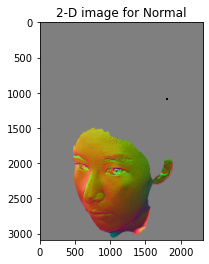

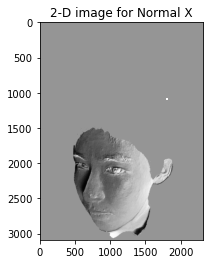

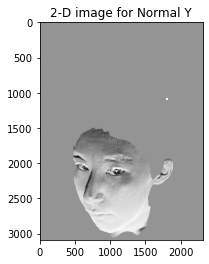

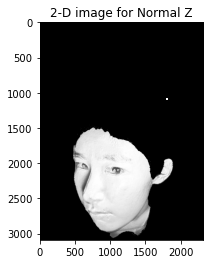

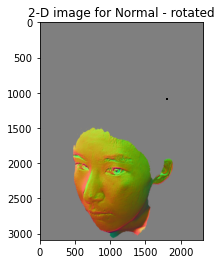

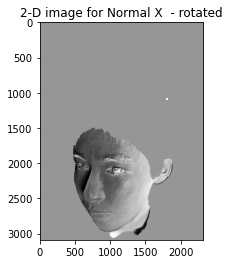

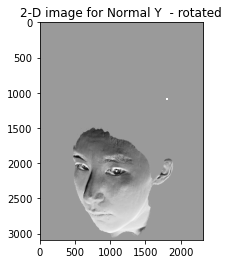

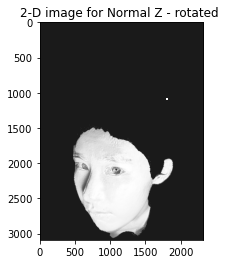

array([[[-0.,  0., -0.],
        [-0.,  0., -0.],
        [-0.,  0., -0.],
        ...,
        [-0., -0., -0.],
        [-0., -0., -0.],
        [-0., -0., -0.]],

       [[-0.,  0., -0.],
        [-0.,  0., -0.],
        [-0.,  0., -0.],
        ...,
        [-0., -0., -0.],
        [-0.,  0., -0.],
        [-0.,  0., -0.]],

       [[ 0.,  0., -0.],
        [ 0.,  0., -0.],
        [-0.,  0., -0.],
        ...,
        [-0.,  0., -0.],
        [-0.,  0., -0.],
        [-0.,  0., -0.]],

       ...,

       [[ 0., -0., -0.],
        [ 0., -0., -0.],
        [ 0., -0., -0.],
        ...,
        [-0., -0., -0.],
        [-0.,  0., -0.],
        [-0.,  0., -0.]],

       [[ 0., -0., -0.],
        [ 0., -0., -0.],
        [ 0., -0., -0.],
        ...,
        [-0.,  0., -0.],
        [-0.,  0., -0.],
        [-0.,  0., -0.]],

       [[ 0., -0., -0.],
        [ 0.,  0., -0.],
        [ 0.,  0., -0.],
        ...,
        [-0.,  0., -0.],
        [-0.,  0., -0.],
        [-0.,  0., -0.]]

In [16]:
surface_normal(I, size)